In [38]:
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

az.rcParams["stats.hdi_prob"] = 0.89
az.style.use("arviz-docgrid")
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

### Code 5.1

In [9]:
from sklearn.preprocessing import StandardScaler

d = pd.read_csv("./Data/WaffleDivorce.csv", delimiter=";")
d[["A", "D"]] = StandardScaler().fit_transform(d[["MedianAgeMarriage", "Divorce"]])
d.head()

Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
0     Alabama  AL        4.78               25.3      20.2         1.27   
1      Alaska  AK        0.71               25.2      26.0         2.93   
2     Arizona  AZ        6.33               25.8      20.3         0.98   
3    Arkansas  AR        2.92               24.3      26.4         1.70   
4  California  CA       37.25               26.8      19.1         0.39   

   Divorce  Divorce SE  WaffleHouses  South  Slaves1860  Population1860  \
0     12.7        0.79           128      1      435080          964201   
1     12.5        2.05             0      0           0               0   
2     10.8        0.74            18      0           0               0   
3     13.5        1.22            41      1      111115          435450   
4      8.0        0.24             0      0           0          379994   

   PropSlaves1860         A         D  
0            0.45 -0.612445  1.671000  
1            0.00 -0.693671  1.560044  
2            0.00 -0.206314  0.616916  
3            0.26 -1.424706  2.114824  
4            0.00  0.605947 -0.936470

### Code 5.2

In [10]:
d.MedianAgeMarriage.std()

1.2436303013880823

### Code 5.3

Sample prior slopes and plot

In [22]:
with pm.Model() as m5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = a + bA*d.A
    D = pm.Normal("D", mu, sigma, observed=d.D)

In [23]:
with m5_1:
    priors = pm.sample_prior_predictive().prior
    trace5_1 = pm.sample()

Sampling: [D, a, bA, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


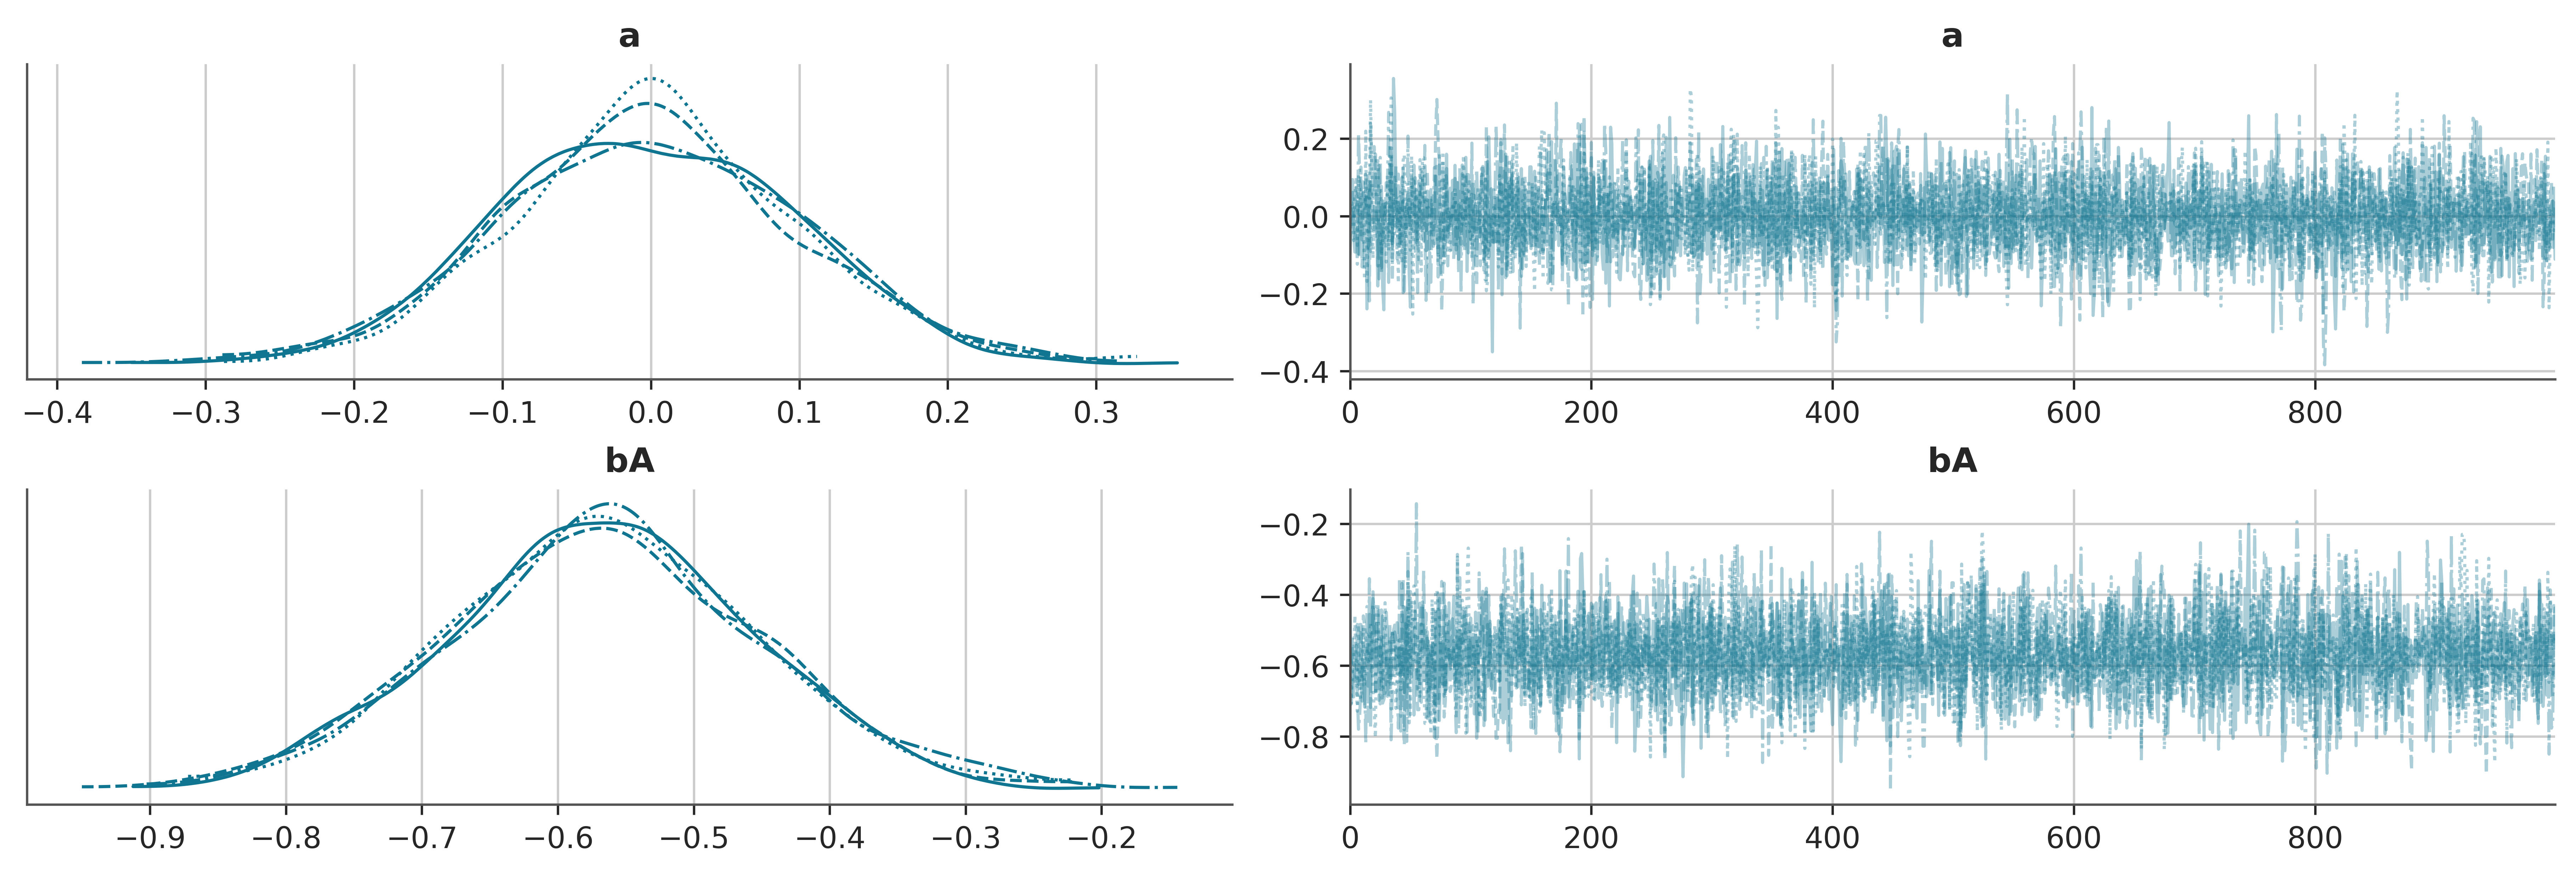

In [24]:
az.plot_trace(trace5_1, var_names=["a", "bA"]);

### Code 5.4

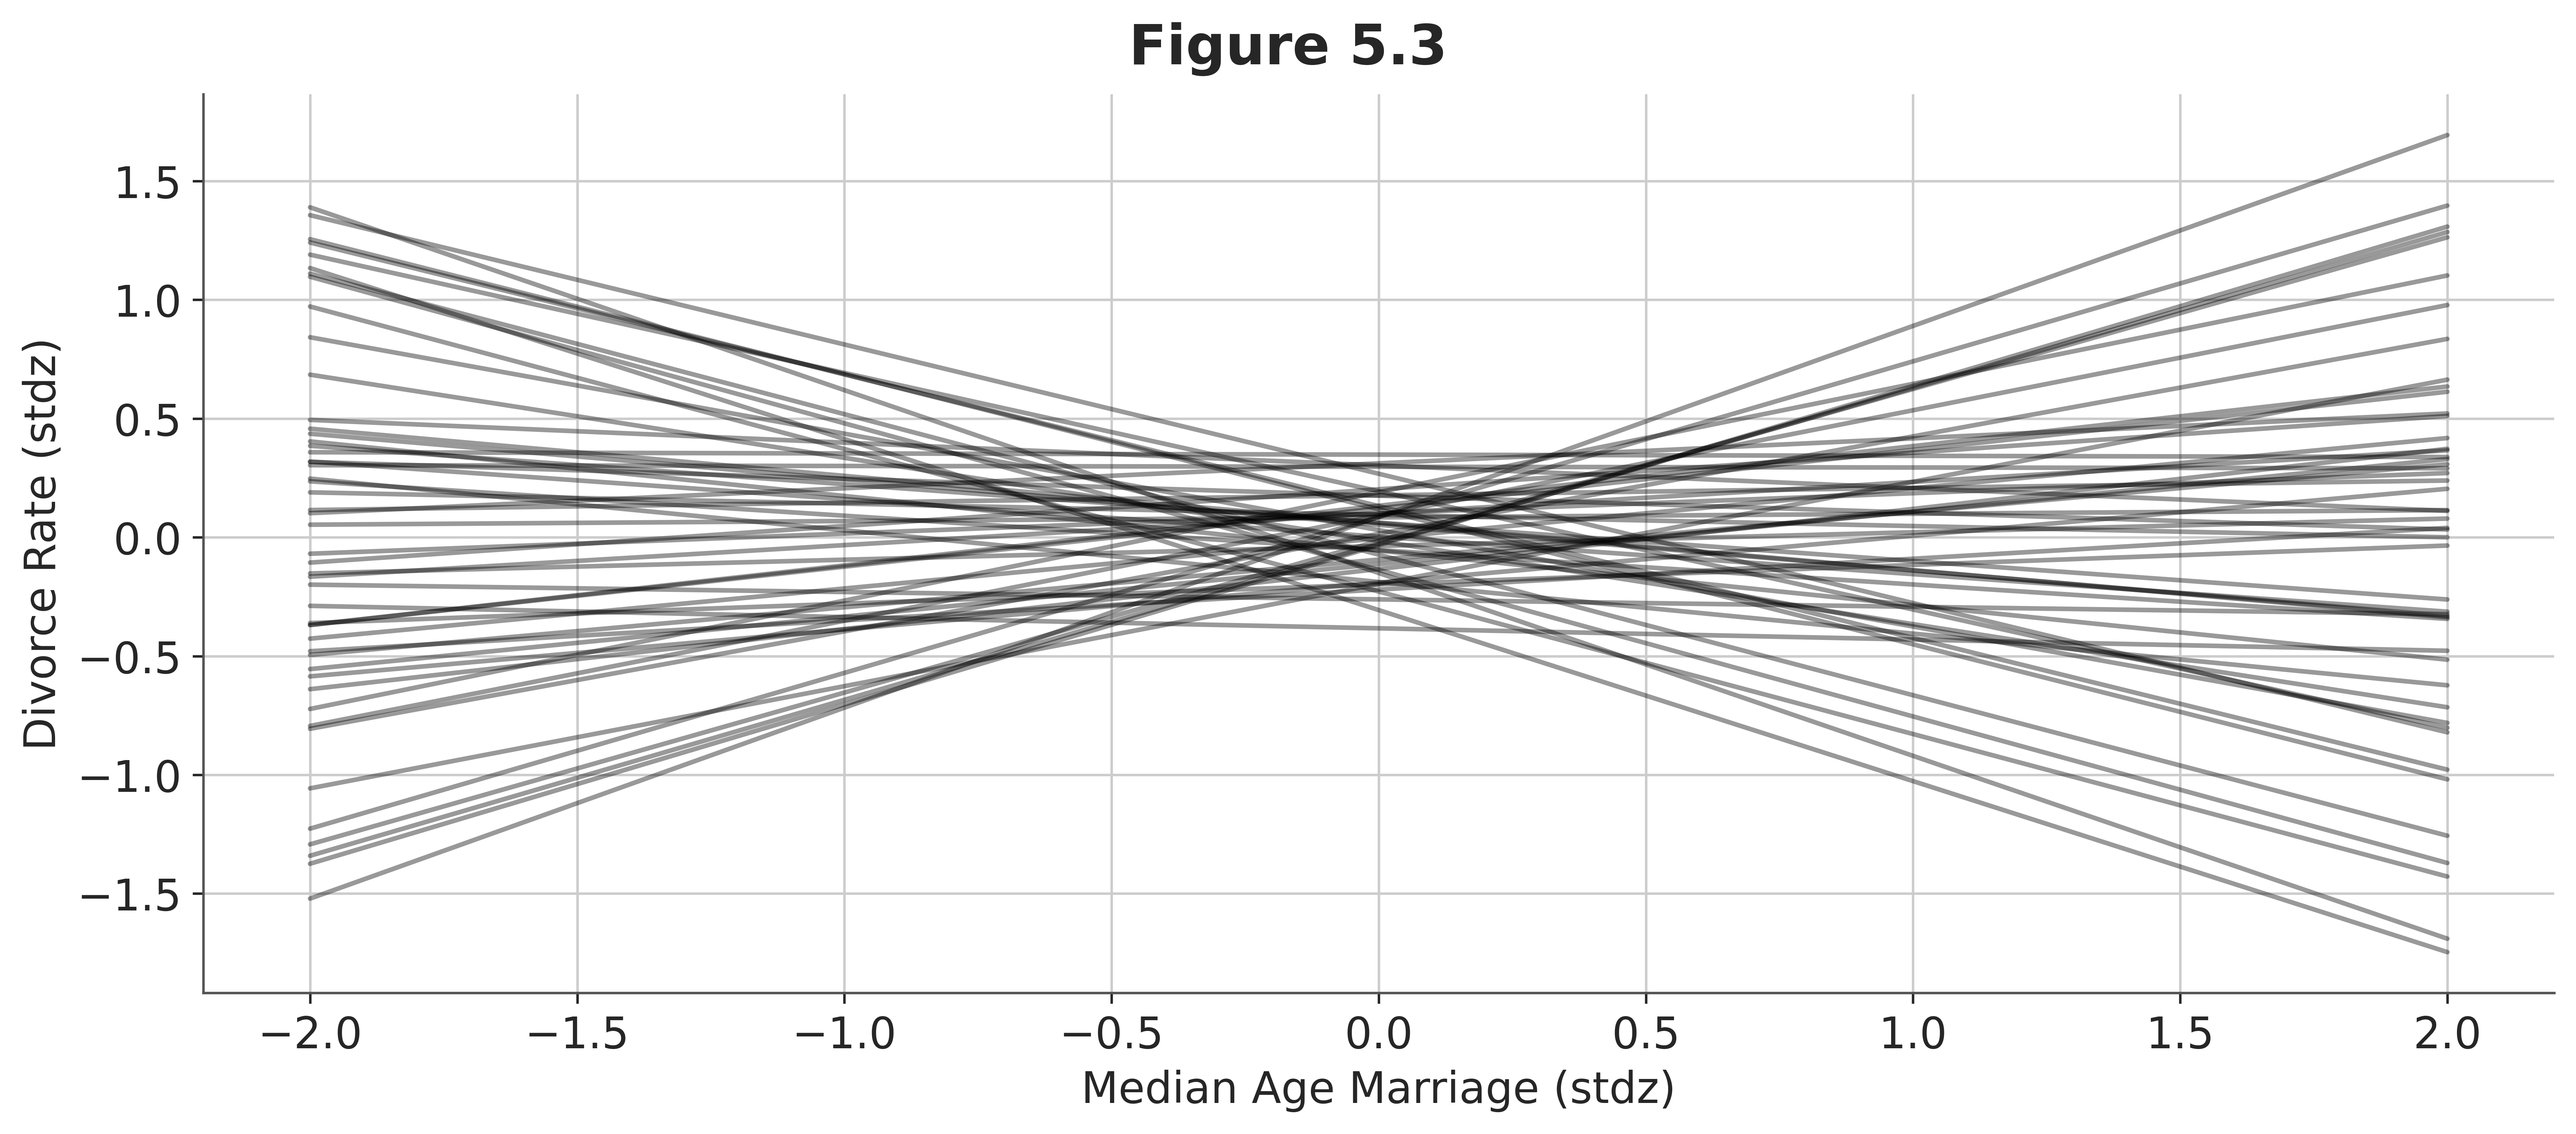

In [42]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

prior_samp_a = np.array(az.extract(priors).a[:50])
prior_samp_bA = np.array(az.extract(priors).bA[:50])

for a, ba in zip(prior_samp_a, prior_samp_bA):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (stdz)")
ax.set_ylabel("Divorce Rate (stdz)")
fig.suptitle("Figure 5.3");

### Code 5.5

In [ ]:
with m5_1:
    idata = pm.sample()

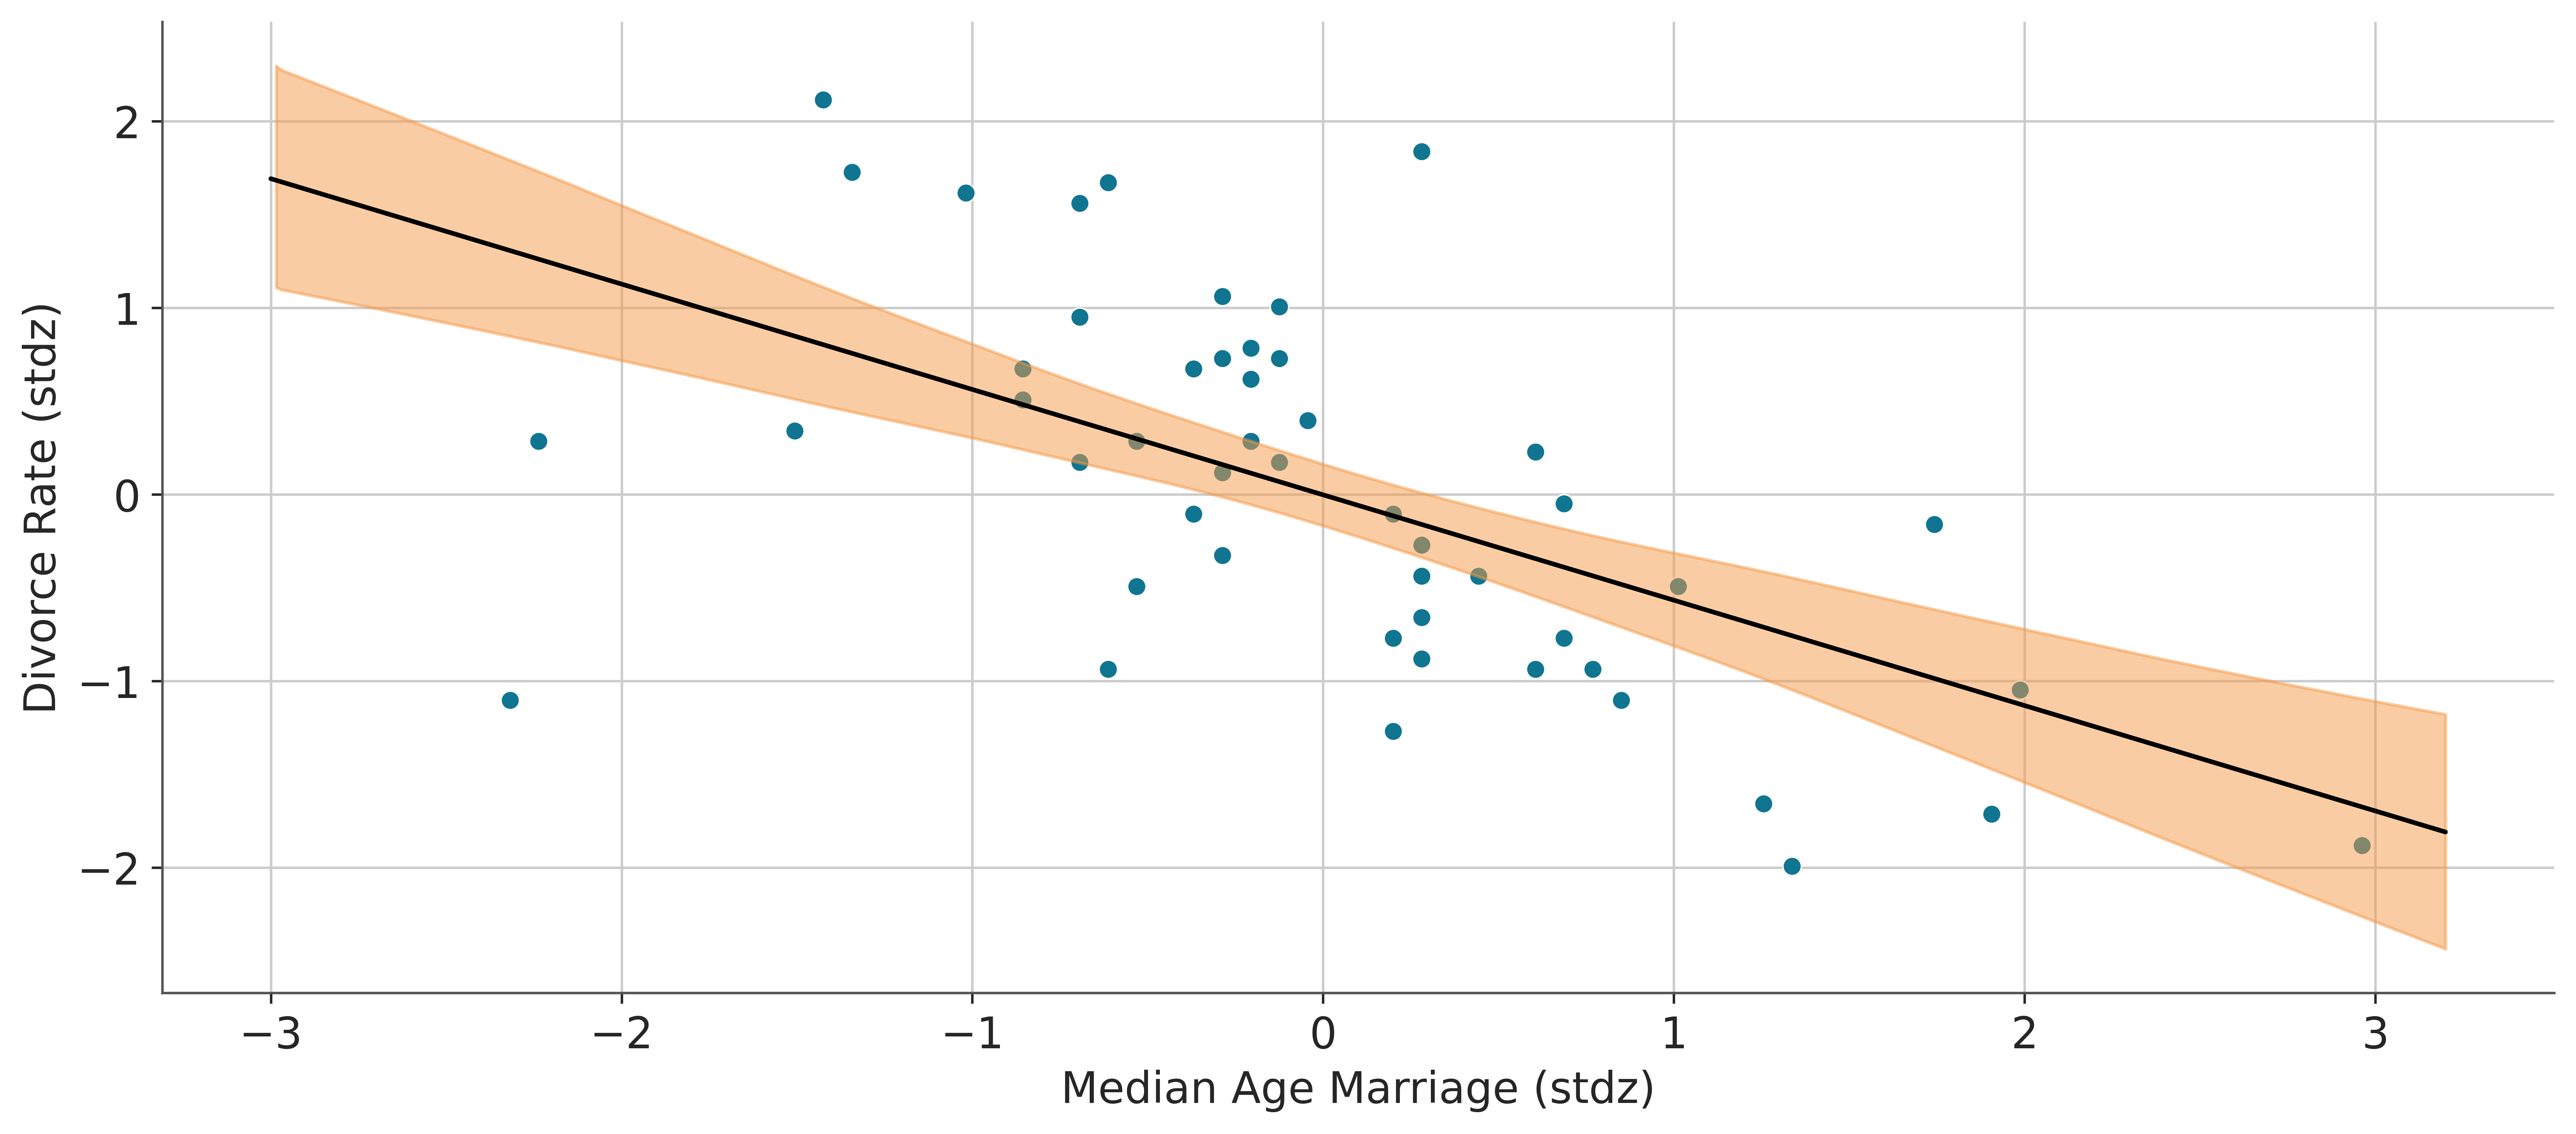

In [67]:
post = idata.posterior
A_seq = np.linspace(-3, 3.2, 30)
post_bA, A_seq_ex = xr.broadcast(post.bA, xr.DataArray(A_seq))
mu_draws = post.a + post_bA * A_seq_ex

_, ax = plt.subplots()
ax.plot(A_seq, mu_draws.mean(("chain", "draw")), color="k")
sns.scatterplot(ax=ax, data=d, x="A", y="D")
az.plot_hdi(A_seq, mu_draws, ax=ax, color="C2")
ax.set_xlabel("Median Age Marriage (stdz)")
ax.set_ylabel("Divorce Rate (stdz)");

### Code 5.6

In [85]:
d["M"] = StandardScaler().fit_transform(d.Marriage.to_numpy().reshape(-1, 1))

with pm.Model() as m5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = a + bM*d.M
    D = pm.Normal("D", mu, sigma, observed=d.D)
    trace5_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


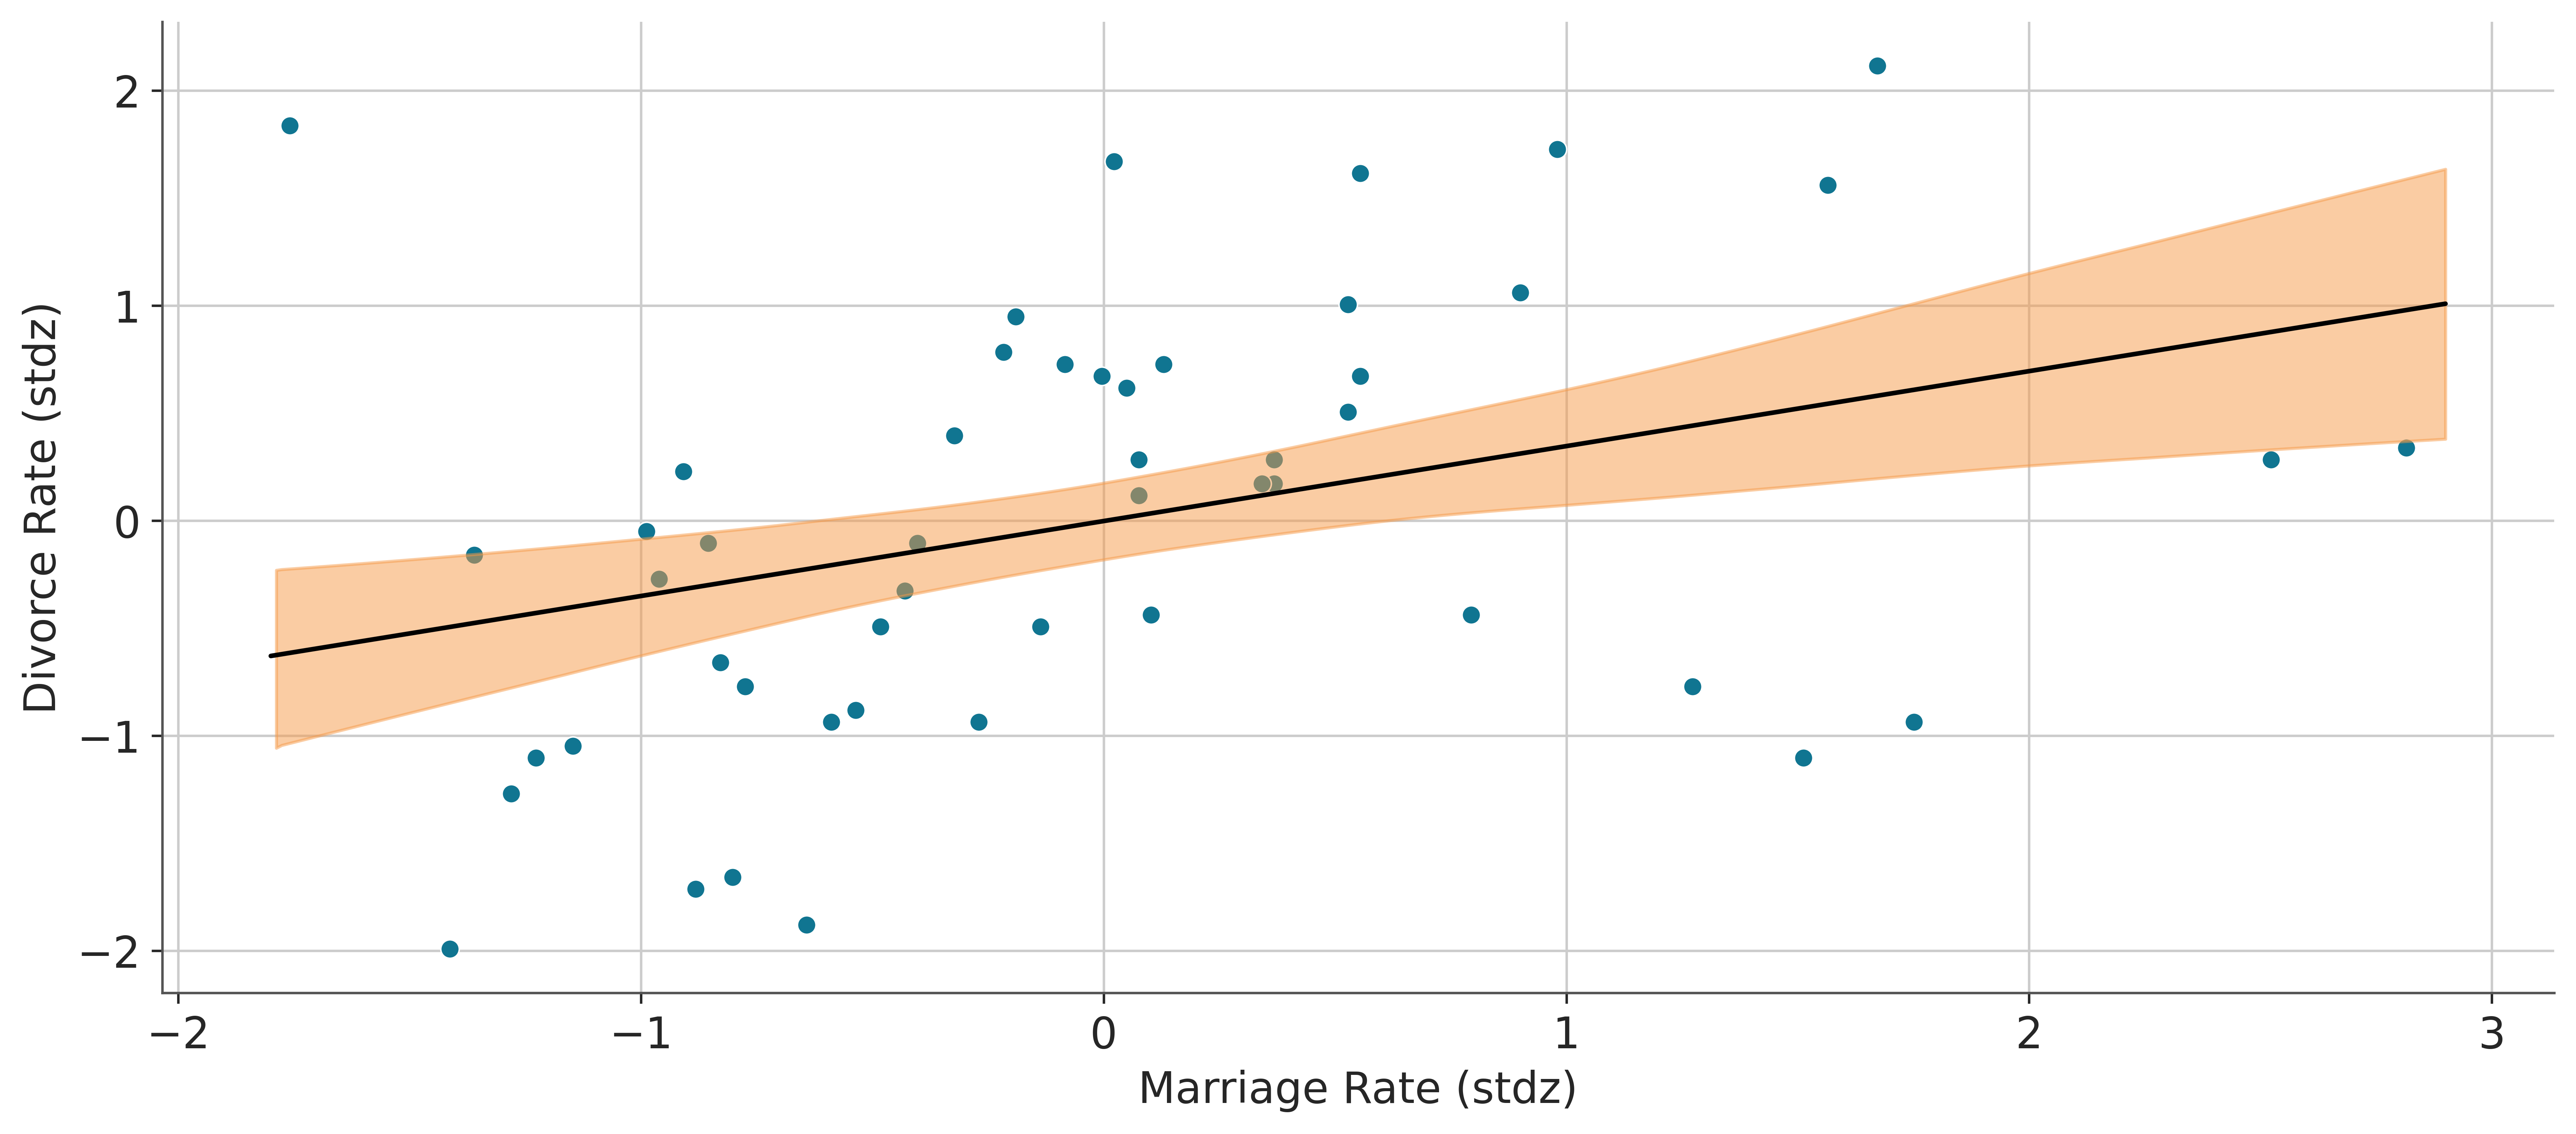

In [79]:
post = idata.posterior
M_seq = np.linspace(-1.8, 2.9, 30)
post_bM, M_seq_ex = xr.broadcast(post.bM, xr.DataArray(M_seq))
mu_draws = post.a + post_bM * M_seq_ex

_, ax = plt.subplots()
ax.plot(M_seq, mu_draws.mean(("chain", "draw")), color="k")
sns.scatterplot(ax=ax, data=d, x="M", y="D")
az.plot_hdi(M_seq, mu_draws, ax=ax, color="C2")
ax.set_xlabel("Marriage Rate (stdz)")
ax.set_ylabel("Divorce Rate (stdz)");

### Code 5.10

In [104]:
with pm.Model() as m5_3:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM*d.M + bA*d.A)
    D = pm.Normal("D", mu, sigma, observed=d.D)
    trace5_3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [105]:
az.summary(trace5_3, var_names=["a", "bM", "bA", "sigma"], kind="stats", round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%
a     -0.00  0.10     -0.16       0.16
bM    -0.06  0.16     -0.31       0.19
bA    -0.60  0.16     -0.86      -0.35
sigma  0.84  0.09      0.70       0.98

In [ ]:
az.plot_forest([trace5_3, trace5_2, trace5_1],
    model_names=["5.3", "5.2", "5.1"],
    var_names=["bA", "bM"],
    combined=True
);

### Code 5.15

In [127]:
post = trace5_3.posterior
mu_mean = post.mu.mean(("chain", "draw"))
mu_PI = az.hdi(post.mu)

with m5_3:
    post_pred = pm.sample_posterior_predictive(trace5_3).posterior_predictive
    
D_sim  = post_pred.D
D_sim_mean = D_sim.mean(("chain", "draw"))
D_PI = az.hdi(D_sim)

Sampling: [D]


### Code 5.16

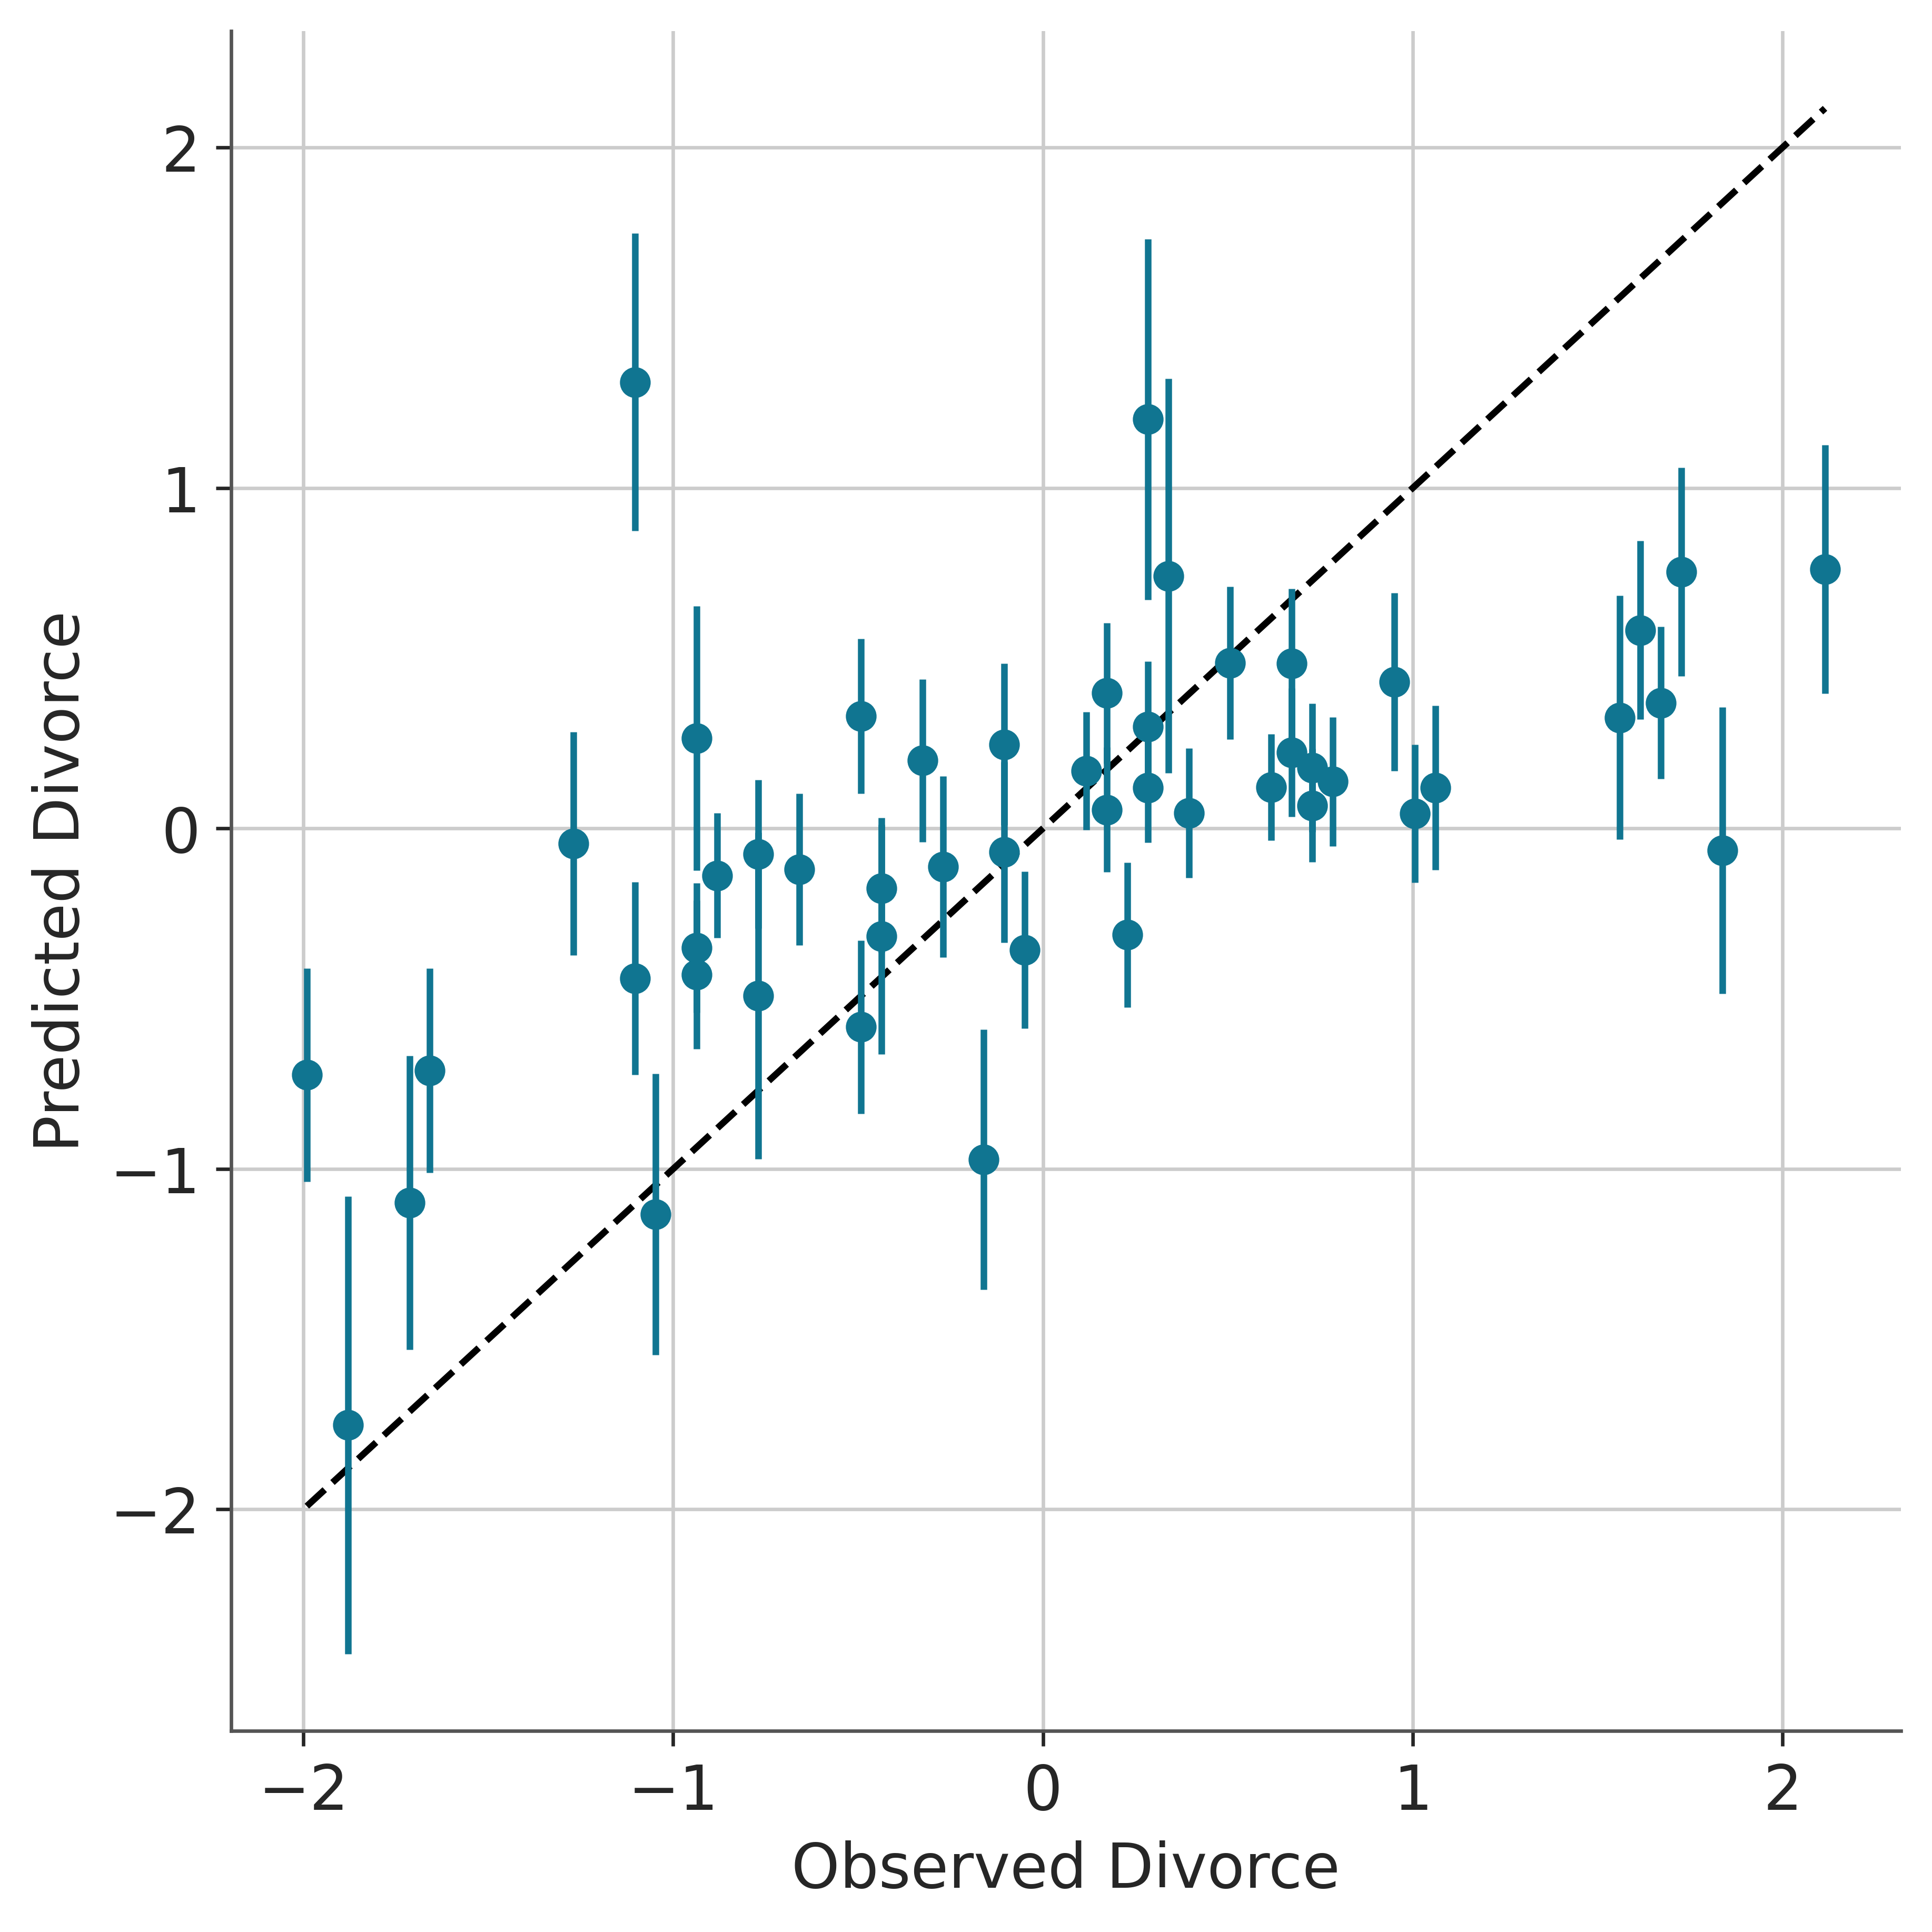

In [136]:
_, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=d.D, y=mu_mean, ax=ax);
min_x, max_x = d.D.min(), d.D.max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

plt.errorbar(
    d.D,
    mu_mean,
    yerr=np.abs(np.array(mu_mean) - mu_PI.min(dim="hdi").to_array()),
    fmt="C0o",
)

ax.set(xlabel="Observed Divorce", ylabel="Predicted Divorce");